In [1]:
!pip install mir-eval
!pip install music21 pretty_midi
!apt install -y fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install abjad
!apt-get install lilypond

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir-eval: filename=mir_eval-0.7-py3-none-any.whl size=100703 sha256=86b72c0e510699348291bc5bf3c89cc29ea22c95a181381dc0f65480f55beaaf
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir-eval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=72539c59d545e773ca6e42585fa26ad49b2a172da1aa39dc7029562a90ea30ab
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
Reading package lists... Done
Building dependency tree... Done
Reading state information..

In [2]:
import os
import sys
import copy
import mir_eval
import numpy as np
import pretty_midi
from music21 import *
from IPython.display import Image

In [3]:
EVAL_TOLERANCE = 0.05
OCTAVE_INVARIANT_RADIUS = 16


def trim_midi(ref_midi_data, est_midi_data):
    ref_notes = []
    for i in ref_midi_data.instruments:
        if i.is_drum:
            continue
        for n in i.notes:
            ref_notes.append(n)
    segment_start = ref_notes[0].start
    segment_end = ref_notes[-1].end

    num_dropped = 0
    for i in est_midi_data.instruments:
        if i.is_drum:
            continue
        i.notes = [
            n for n in i.notes if n.start >= segment_start and n.start <= segment_end
        ]

    return est_midi_data


def midi_to_mir_eval(midi_data, dummy_offsets = True):
    notes = []
    for i in midi_data.instruments:
        if i.is_drum:
            continue
        for n in i.notes:
            notes.append((n.start, n.end, n.pitch))
    notes = sorted(notes)
    note_onsets = [s for s, _, _ in notes]
    note_offsets = [e for _, e, _ in notes]
    if dummy_offsets and len(note_onsets) > 0:
        note_offsets = note_onsets[1:] + [note_onsets[-1] + 1]
    intervals = np.stack([note_onsets, note_offsets], axis = 1).astype(np.float64)
    pitches = np.array([p for _, _, p in notes], dtype = np.int64)
    return intervals, pitches


def extract_notes(ref_midi_file, est_midi_file):
    ref_midi_data = pretty_midi.PrettyMIDI(ref_midi_file)
    est_midi_data = pretty_midi.PrettyMIDI(est_midi_file)
    ref_midi_data = copy.deepcopy(ref_midi_data)
    est_midi_data = copy.deepcopy(est_midi_data)

    est_midi_data = trim_midi(ref_midi_data, est_midi_data)

    ref_intervals, ref_pitches = midi_to_mir_eval(ref_midi_data, dummy_offsets = False)
    est_intervals, est_pitches = midi_to_mir_eval(est_midi_data, dummy_offsets = False)

    return ref_intervals, ref_pitches, est_intervals, est_pitches


def mir_eval_onset_prf(ref_intervals, ref_pitches, est_intervals, est_pitches):
    m_to_f = lambda m: 440.0 * np.power(2, (m.astype(np.float32) - 69) / 12)
    p, r, f1, _ = mir_eval.transcription.precision_recall_f1_overlap(
            ref_intervals,
            m_to_f(ref_pitches),
            est_intervals,
            m_to_f(est_pitches),
            onset_tolerance = EVAL_TOLERANCE,
            pitch_tolerance = 1.0,
            offset_ratio = None,
        )
    return p, r, f1


def evaluate(ref_intervals, ref_pitches, est_intervals, est_pitches):
    octaves = list(range(-OCTAVE_INVARIANT_RADIUS, OCTAVE_INVARIANT_RADIUS + 1))
    ps = []
    rs = []
    f1s = []
    for o in octaves:
        p, r, f1 = mir_eval_onset_prf(
            ref_intervals,
            (o * 12) + ref_pitches,
            est_intervals,
            est_pitches
        )
        ps.append(p)
        rs.append(r)
        f1s.append(f1)

    best_octave_idx = np.argmax(f1s)
    return (
        ps[best_octave_idx],
        rs[best_octave_idx],
        f1s[best_octave_idx]
    )



We have to load a midi file to be able to test it (here i am using F01_0024_0001_1.mid)

In [4]:
def midi_number_to_texte(midi_number):
    notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    octave = int(midi_number / 12) - 1
    note = notes[midi_number % 12]
    return note + str(octave)


def write_notes_to_file(notes, filename):
    with open(filename, 'w') as f:
        for note in notes:
            note_name = midi_number_to_texte(note[0])
            start_time = note[1]
            end_time = note[2]
            f.write(f"{note_name} {start_time} {end_time}\n")



ref_intervals, ref_pitches, est_intervals, est_pitches = extract_notes("F01_0024_0001_1.mid", "F01_0024_0001_1.mid") #change this line if u want to use another file
notes = [(pitch, interval[0], interval[1]) for pitch, interval in zip(ref_pitches, ref_intervals)]
print(notes)
write_notes_to_file(notes, "note.txt")


[(64, 0.0, 0.41123178124999993), (67, 0.4347824999999999, 0.8460142812499998), (71, 0.8695649999999998, 1.2807967812499996), (67, 1.3043474999999998, 1.7155792812499997), (69, 1.7391299999999996, 2.5634051562499995), (67, 2.6086949999999995, 3.0199267812499992), (66, 3.0434774999999994, 3.454709281249999), (71, 3.4782599999999992, 4.302535156249999), (69, 4.347824999999999, 5.172100156249999), (64, 5.217389999999999, 6.867751906249999), (67, 6.9565199999999985, 7.367751781249998), (71, 7.391302499999998, 7.802534281249998), (74, 7.826084999999998, 8.237316781249998), (74, 8.260867499999998, 8.672099281249999), (76, 8.695649999999999, 9.519925156249998), (74, 9.565214999999998, 9.976446781249997), (72, 9.999997499999997, 10.411229281249998), (71, 10.434779999999998, 13.737315406249998)]


In [5]:
def text_to_score(filename):
    s = stream.Score()

    with open(filename, 'r') as f:
        lines = f.readlines()

    for line in lines:
        note_name, start_time, end_time = line.strip().split()
        duration_in_seconds = float(end_time) - float(start_time)
        duration_in_quarters = duration_in_seconds
        expressible_durations = [4, 2 ,1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128]
        closest_duration = min(expressible_durations, key=lambda x:abs(x-duration_in_quarters))
        new_note = note.Note(note_name, quarterLength=closest_duration)
        s.append(new_note)

    time_signature = meter.TimeSignature('2/4')
    s.insert(0, time_signature)
    s.write('lilypond', 'output.ly')

text_to_score("note.txt")


In [6]:
!lilypond -dbackend=eps -dno-gs-load-fonts -dinclude-eps-fonts --png output.ly


GNU LilyPond 2.22.1
Processing `output.ly'
Parsing...
Interpreting music...[8][8]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `output.eps'...
Converting to PNG...
Layout output to `output-1.eps'...
Writing output-systems.texi...
Writing output-systems.tex...
Writing output-systems.count...
Success: compilation successfully completed


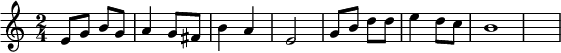

In [7]:
Image('output.png')